### Prepare the Dataset

In [1]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# split to test and validation
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=.5, random_state=0)

# prepare train and test sets
train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.
val_images = val_images / 255.
test_images = test_images / 255.

In [2]:
label_mapper = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

### Visualize the Dataset

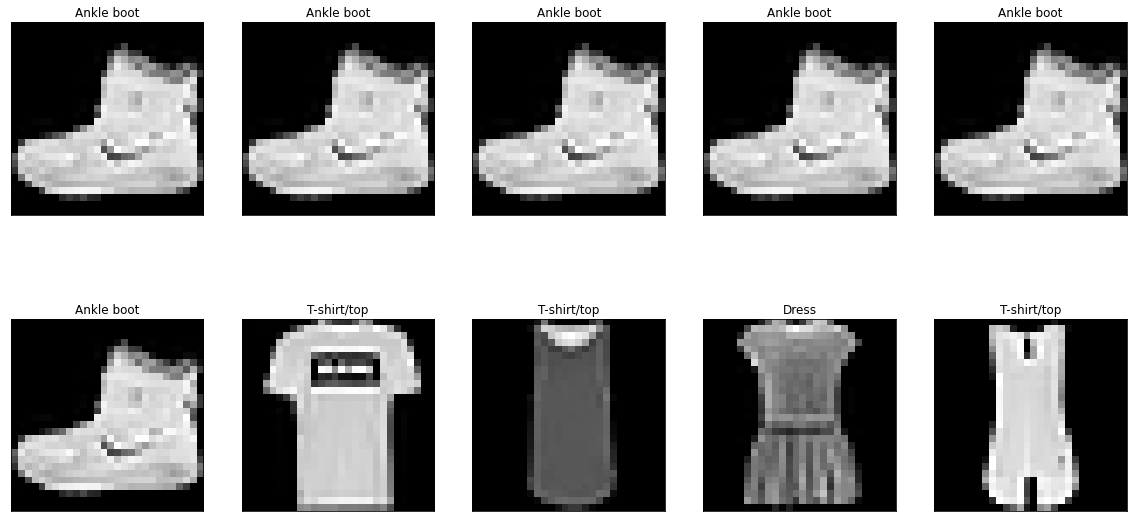

In [3]:
from matplotlib import pyplot as plt

row = 2
col = 5
_, axs = plt.subplots(row,col, figsize=(row * 10, col * 2))

for i in range(row):
    for j in range(col):
        temp_image = train_images[i * j]
        temp_image *= 255.
        axs[i,j].set_title(label_mapper[train_labels[i * j]])
        axs[i,j].imshow(temp_image, cmap='gray')
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        del temp_image
plt.show()

### Prepare the Dataset

In [4]:
import random
import numpy as np

def create_pairs(images, labels):
    """
    Create a positive and negative pair images
    
    Parameter
    ----------
    images: numpy array of images
    labels: numpy array of labels
    
    Return
    ----------
    pair_images: numpy array of random paired image
    pair_labels: numpy array of binary value (1 is positive, 0 is negative)
    """
    
    pair_images, pair_labels = [], []
    n = min([len(labels[l]) for l in range(10)]) - 1
    
    for l in range(10):
        for i in range(n):
            # create positive pair image
            z1, z2 = labels[l][i], labels[l][i + 1]
            pair_images += [[images[z1], images[z2]]]
            
            inc = random.randrange(1, 10)
            dn = (l + inc) % 10
            
            # create negative pair image
            z1, z2 = labels[l][i], labels[dn][i]
            pair_images += [[images[z1], images[z2]]]
            pair_labels += [1,0]
    return np.array(pair_images), np.array(pair_labels)

def create_pairs_on_set(images, labels):
    """
    Create a set for training data
    
    Parameter
    ----------
    images: numpy array of images
    labels: numpy array of labels
    
    Return
    ----------
    pairs: numpy array of random paired image
    y: numpy array of binary value (1 is positive, 0 is negative)
    """
    
    digit = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit)
    y = y.astype('float32')
    return pairs, y

In [5]:
# create pairs on train, validation and test sets
train_image_pairs, train_label_pairs = create_pairs_on_set(train_images, train_labels)
val_image_pairs, val_label_pairs = create_pairs_on_set(val_images, val_labels)
test_image_pairs, test_label_pairs = create_pairs_on_set(test_images, test_labels)

In [6]:
def show_image(anchor_image, image):
    """
    Display pair data
    
    Parameter
    ----------
    image: a set of image pair
    ax: an integer for axis
    
    Return
    ----------
    None
    """
    
    _, axs = plt.subplots(1,2)
    axs[0].imshow(anchor_image)
    axs[0].grid(False)
    axs[1].imshow(image)
    axs[1].grid(False)
    plt.show()

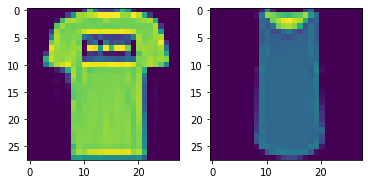

The train pair is the same


In [7]:
# array index
index = 0

# show images at this index
show_image(train_image_pairs[index][0], train_image_pairs[index][1])
print('The train pair is', 'the same' if train_label_pairs[index] == 1 else 'not the same')

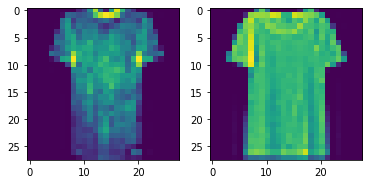

The validation pair is the same


In [8]:
show_image(val_image_pairs[index][0], val_image_pairs[index][1])
print('The validation pair is', 'the same' if val_label_pairs[index] == 1 else 'not the same')

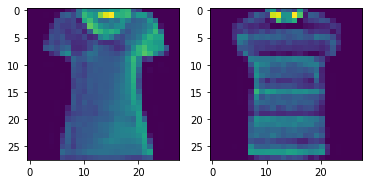

The test pair is the same


In [9]:
show_image(test_image_pairs[index][0], test_image_pairs[index][1])
print('The test pair is', 'the same' if test_label_pairs[index] == 1 else 'not the same')

### Develop Base Network

In [10]:
from tensorflow import keras
from keras import Model
from keras import layers
from keras.utils.vis_utils import plot_model

class BaseNetwork(Model):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.flatten = layers.Flatten(name='flatten')
        self.d1 = layers.Dropout(.2, name='dropout_1')
        self.fc1 = layers.Dense(256, activation='relu', name='fully_1')
        self.d2 = layers.Dropout(.2, name='dropout_2')
        self.fc2 = layers.Dense(128, activation='relu', name='fully_2')
    
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.d1(x)
        x = self.fc1(x)
        x = self.d2(x)
        return self.fc2(x)

base_network = BaseNetwork()

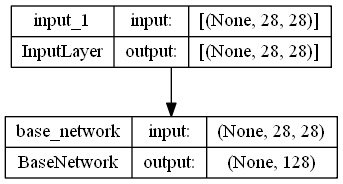

In [11]:
input_shape = train_images[0].shape
inputs = layers.Input(shape=input_shape)

# create base model and display model layer
output = base_network(inputs)
base_model = Model(inputs, output)
plot_model(base_model, show_shapes=True, to_file='base-model.png')

### Develop Distance Measurement

In [12]:
import keras.backend as K

def euclidean(vect):
    """
    Calculate the euclidean distance between vector
    
    Parameter
    ----------
    vect: 
    
    Return
    ----------
    squared root sum:
    """
    
    x, y = vect
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euclidean_output_shape(shapes):
    """
    Get shape of vector
    
    Paramter
    ----------
    shapes: shapes of 2 vector
    
    Return
    euclidean output shape: (row from vector 1, 1)
    """
    
    shape1, shape2 = shapes
    return (shape1[0], 1)

### Define Model

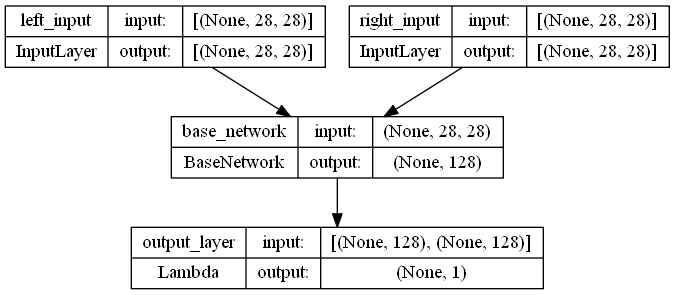

In [13]:
# define the input and output layer for left network
left_input = layers.Input(shape=input_shape, name='left_input')
left_output = base_network(left_input)

# define the input and output layer for right network
right_input = layers.Input(shape=input_shape, name='right_input')
right_output = base_network(right_input)

# measure similarity between vector
output = layers.Lambda(euclidean, name='output_layer', output_shape=euclidean_output_shape)([left_output, right_output])
model = Model([left_input, right_input], output)
plot_model(model, show_shapes=True, to_file='siamese-model.png')

### Define Contrastive Loss with Margin for Twin Network

In [14]:
def contrastive_loss_with_margin(margin):
    """
    Calculate contrastive loss with margin
    
    Parameter
    ----------
    margin: constant number [0-1]
    
    Return
    ----------
    contrastive_loss: function
    """
    
    def contrastive_loss(y_true, y_pred):
        """
        Calculate contrastive loss
        
        Parameter
        ----------
        y_true: ground truth label
        y_pred: prediction label
        
        Return
        ----------
        contrastive loss: (y_true * squared prediction + (1 - y_true) * squared margin)
        """
        
        squared_pred = K.square(y_pred)
        squared_margin = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * squared_pred + (1 - y_true) * squared_margin)
    return contrastive_loss

In [15]:
optimizer = keras.optimizers.RMSprop()
loss = contrastive_loss_with_margin(margin=1)

In [16]:
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28)]     0           []                               
                                                                                                  
 base_network (BaseNetwork)     (None, 128)          233856      ['left_input[0][0]',             
                                                                  'right_input[0][0]']            
                                                                                                  
 output_layer (Lambda)          (None, 1)            0           ['base_network[1][0]',     

### Perform Training

In [17]:
history = model.fit(
    [train_image_pairs[:, 0], train_image_pairs[:, 1]],
    train_label_pairs,
    epochs=20,
    batch_size=256,
    validation_data=([val_image_pairs[:, 0], val_image_pairs[:, 1]], val_label_pairs)
)

Epoch 1/20
469/469 [==============================] - 3s 4ms/step - loss: 626836720698497173553152.0000 - val_loss: 0.0980
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 634997315280886550233088.0000 - val_loss: 0.0935
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 398197290269008472309760.0000 - val_loss: 0.0874
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 296206034919002778632192.0000 - val_loss: 0.0839
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 457652875800831267438592.0000 - val_loss: 0.0836
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 507266979254141940924416.0000 - val_loss: 0.0838
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 232235716861530627637248.0000 - val_loss: 0.0831
Epoch 8/20
469/469 [==============================] - 3s 6ms/step - loss: 595113473009690456621056.0000 - val_loss: 0.0795
Epoch 9/20
469/4

### Model Evaluation

In [18]:
def compute_accuracy(y_true, y_pred):
    """
    Compute binary accuracy with fixed threshold
    
    Parameter
    ----------
    y_true: ground truth label
    y_pred: predicted label
    
    Return
    ----------
    accuracy: mean prediction
    """
    
    yhat = y_pred.ravel() < .5
    return np.mean(yhat == y_true)

In [19]:
# compute validation accuracy
y_pred_val = model.predict([val_image_pairs[:,0], val_image_pairs[:,1]])
val_accuracy = compute_accuracy(val_label_pairs, y_pred_val)

# compute test accuracy
y_pred_test = model.predict([test_image_pairs[:,0], test_image_pairs[:,1]])
test_accuracy = compute_accuracy(test_label_pairs, y_pred_test)

print("val_accuracy: {} - test_accuracy: {}".format(val_accuracy, test_accuracy))

303/303 [==============================] - 1s 2ms/step
val_accuracy: 0.899154334038055 - test_accuracy: 0.8912190082644628


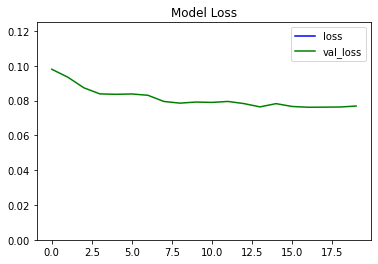

In [20]:
def plot_training_step(metric, title, ylim=1):
    """
    Visualize training step
    
    Parameter
    ----------
    metric: metric to be visualized
    title: title of the plot
    ylim: Optional, limit of the y axis
    
    Return
    ----------
    None
    """
    
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric], color='blue', label=metric)
    plt.plot(history.history['val_' + metric], color='green', label='val_' + metric)
    plt.legend([metric, 'val_' + metric], loc='upper right')
    plt.show()

plot_training_step('loss', 'Model Loss', .125)

In [21]:
# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    """
    Visualize image with distance
    
    Parameter
    ----------
    left: numpy array left image on pair
    right: numpy array right image on pair
    predictions: distance prediction between image
    labels: ground truth label
    title: plot title
    n: total pair want to visualize
    
    Return
    ----------
    None
    """
    
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28 * n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5:
            t.set_color('red') # bad predictions in red
        else:
            t.set_color('green')
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28 * n])
    plt.imshow(right)

C:\Users\micha\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


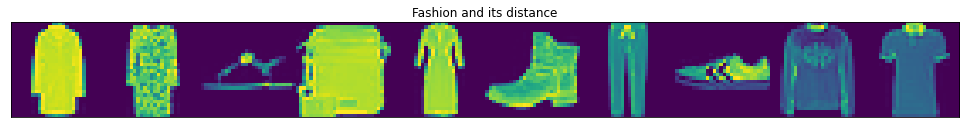

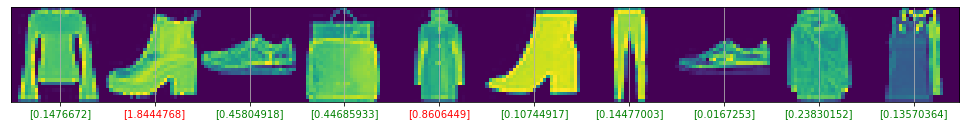

In [22]:
y_pred = np.squeeze(y_pred_test)
idx = np.random.choice(len(y_pred_test), size=10)
display_images(
    test_image_pairs[:, 0][idx],
    test_image_pairs[:, 1][idx],
    y_pred_test[idx],
    test_label_pairs[idx],
    "Fashion and its distance",
    10
)

In [23]:
model.save("siamese_model.h5")